Regression Results for AAPL:
Alpha: 0.000208
Factor Loadings (Betas):
MKT-RF: 0.012823
SMB: -0.001226
HML: -0.007059
RMW: 0.004549
CMA: 0.008439


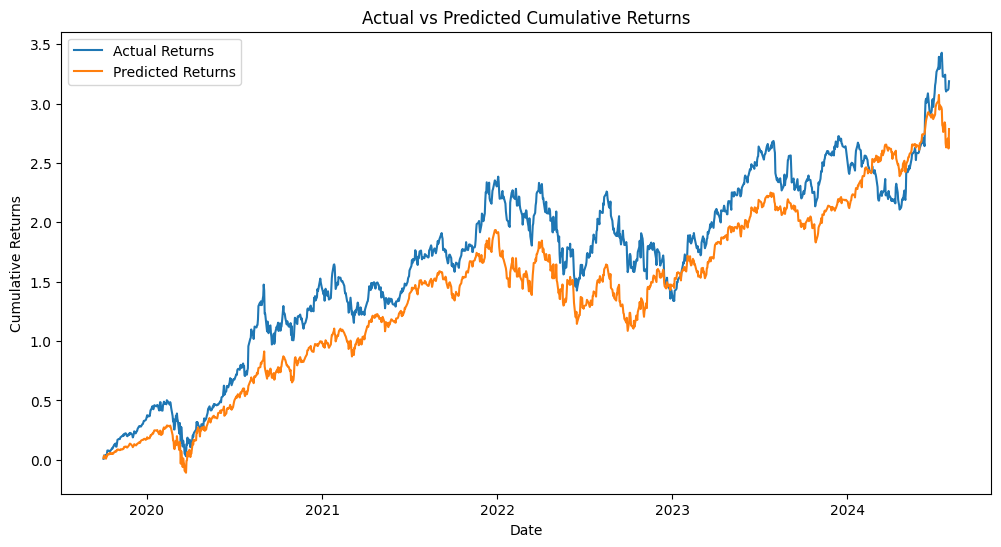


Estimated Daily Cost of Equity: 0.000092
Estimated Yearly Cost of Equity: 0.023465 (2.35%)

Total Return over the period: 318.78%
MKT-RF: 0.012823
SMB: -0.001226
HML: -0.007059
RMW: 0.004549
CMA: 0.008439


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def get_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    stock_data = stock.history(start=start_date, end=end_date)
    returns = np.log(stock_data['Close'] / stock_data['Close'].shift(1)).dropna()
    returns.index = returns.index.tz_localize(None)  #convert to tz-naive
    return returns

def get_ff_factors(start_date, end_date):
    ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_daily_CSV.zip"
    ff_factors = pd.read_csv(ff_url, skiprows=3)
    ff_factors.columns = ['Date', 'MKT-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
    ff_factors['Date'] = pd.to_datetime(ff_factors['Date'], format='%Y%m%d')
    ff_factors.set_index('Date', inplace=True)
    return ff_factors.loc[start_date:end_date]

def calculate_excess_returns(stock_returns, risk_free_rate):
    return stock_returns - risk_free_rate / 100

def run_regression(excess_returns, factors):
    X = factors[['MKT-RF', 'SMB', 'HML', 'RMW', 'CMA']]
    y = excess_returns
    model = LinearRegression().fit(X, y)
    return model

def plot_results(stock_returns, predicted_returns):
    plt.figure(figsize=(12, 6))
    cumulative_actual = np.exp(stock_returns.cumsum()) - 1
    cumulative_predicted = np.exp(predicted_returns.cumsum()) - 1
    plt.plot(stock_returns.index, cumulative_actual, label='Actual Returns')
    plt.plot(stock_returns.index, cumulative_predicted, label='Predicted Returns')
    plt.title('Actual vs Predicted Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()

def main():

    ticker = 'AAPL'
    end_date = datetime.now()
    start_date = end_date - timedelta(days=5*365)

    stock_returns = get_stock_data(ticker, start_date, end_date)

    ff_factors = get_ff_factors(start_date, end_date)

    aligned_data = pd.concat([stock_returns, ff_factors], axis=1).dropna()

    excess_returns = calculate_excess_returns(aligned_data[aligned_data.columns[0]], aligned_data['RF'])

    model = run_regression(excess_returns, aligned_data[['MKT-RF', 'SMB', 'HML', 'RMW', 'CMA']])

    print(f"Regression Results for {ticker}:")
    print(f"Alpha: {model.intercept_:.6f}")
    print("Factor Loadings (Betas):")
    for factor, beta in zip(['MKT-RF', 'SMB', 'HML', 'RMW', 'CMA'], model.coef_):
        print(f"{factor}: {beta:.6f}")


    predicted_returns = model.predict(aligned_data[['MKT-RF', 'SMB', 'HML', 'RMW', 'CMA']])


    plot_results(aligned_data[aligned_data.columns[0]], pd.Series(predicted_returns, index=aligned_data.index))


    risk_free_rate = aligned_data['RF'].mean()
    factor_returns = aligned_data[['MKT-RF', 'SMB', 'HML', 'RMW', 'CMA']].mean()
    daily_cost_of_equity = risk_free_rate / 100 + sum(model.coef_ * factor_returns / 100)
    yearly_cost_of_equity = (1 + daily_cost_of_equity) ** 252 - 1
    print(f"\nEstimated Daily Cost of Equity: {daily_cost_of_equity:.6f}")
    print(f"Estimated Yearly Cost of Equity: {yearly_cost_of_equity:.6f} ({yearly_cost_of_equity:.2%})")


    total_return = np.exp(aligned_data[aligned_data.columns[0]].sum()) - 1
    print(f"\nTotal Return over the period: {total_return:.2%}")

if __name__ == "__main__":
    main()


ticker = 'AAPL'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)


stock_returns = get_stock_data(ticker, start_date, end_date)


ff_factors = get_ff_factors(start_date, end_date)


aligned_data = pd.concat([stock_returns, ff_factors], axis=1).dropna()


excess_returns = calculate_excess_returns(aligned_data[aligned_data.columns[0]], aligned_data['RF'])


model = run_regression(excess_returns, aligned_data[['MKT-RF', 'SMB', 'HML', 'RMW', 'CMA']])


for factor, beta in zip(['MKT-RF', 'SMB', 'HML', 'RMW', 'CMA'], model.coef_):
    print(f"{factor}: {beta:.6f}")


predicted_returns = model.predict(aligned_data[['MKT-RF', 'SMB', 'HML', 'RMW', 'CMA']])




risk_free_rate = aligned_data['RF'].mean()
factor_returns = aligned_data[['MKT-RF', 'SMB', 'HML', 'RMW', 'CMA']].mean()
daily_cost_of_equity = risk_free_rate / 100 + sum(model.coef_ * factor_returns / 100)
yearly_cost_of_equity = (1 + daily_cost_of_equity) ** 252 - 1


total_return = np.exp(aligned_data[aligned_data.columns[0]].sum()) - 1



In [ ]:
import yfinance as yf
import numpy as np
from datetime import datetime, timedelta

def get_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    stock_data = stock.history(start=start_date, end=end_date)
    returns = np.log(stock_data['Close'] / stock_data['Close'].shift(1)).dropna()
    returns.index = returns.index.tz_localize(None)
    return returns

def get_risk_free_rate():
    try:
        tnx = yf.Ticker("^TNX")
        return tnx.info.get('previousClose', tnx.history(period="1d")['Close'].iloc[-1]) / 100
    except:
        return 0.035  # default to 3.5% if unable to fetch

def calculate_wacc(ticker):

    end_date = datetime.now()
    start_date = end_date - timedelta(days=5*365)

    stock_returns = get_stock_data(ticker, start_date, end_date)

    company = yf.Ticker(ticker)
    info = company.info



    cost_of_equity = yearly_cost_of_equity


    try:
        interest_expense = info.get('interestExpense', 0)
        total_debt = info.get('totalDebt', 0)
        if total_debt > 0:
            cost_of_debt = interest_expense / total_debt
        else:
            cost_of_debt = risk_free_rate + 0.05
    except:
        cost_of_debt = risk_free_rate + 0.05

    tax_rate = info.get('effectiveTaxRate', 0.21)  # default to 21% if not available


    market_cap = info.get('marketCap', 0)
    total_debt = info.get('totalDebt', 0)
    total_capital = market_cap + total_debt
    if total_capital > 0:
        weight_equity = market_cap / total_capital
        weight_debt = total_debt / total_capital
    else:
        weight_equity = 1.0
        weight_debt = 0.0

    wacc = (cost_of_equity * weight_equity) + (cost_of_debt * (1 - tax_rate) * weight_debt)

    return wacc, cost_of_equity, cost_of_debt, weight_equity, weight_debt, tax_rate


ticker = 'AAPL'
wacc, cost_of_equity, cost_of_debt, weight_equity, weight_debt, tax_rate = calculate_wacc(ticker)

print(f"WACC Calculation for {ticker}:")
print(f"Cost of Equity: {cost_of_equity:.2%}")
print(f"Cost of Debt: {cost_of_debt:.2%}")
print(f"Weight of Equity: {weight_equity:.2%}")
print(f"Weight of Debt: {weight_debt:.2%}")
print(f"Tax Rate: {tax_rate:.2%}")
print(f"WACC: {wacc:.2%}")

ERROR:yfinance:401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AAPL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AAPL&crumb=%7B%22finance%22%3A%7B%22result%22%3Anull%2C%22error%22%3A%7B%22code%22%3A%22Unauthorized%22%2C%22description%22%3A%22Invalid+Cookie%22%7D%7D%7D


WACC Calculation for AAPL:
Cost of Equity: 2.35%
Cost of Debt: 5.83%
Weight of Equity: 100.00%
Weight of Debt: 0.00%
Tax Rate: 21.00%
WACC: 2.35%
